In [10]:
import pandas as pd
import numpy as np
import shap

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

# Input

In [2]:
train_df = pd.read_csv('/home/howt51/work/vscode_micromamba/kaggle/data/playground-series-s3e18/train.csv')
test_df = pd.read_csv('/home/howt51/work/vscode_micromamba/kaggle/data/playground-series-s3e18/test.csv')

In [3]:
def process(df):
    df['MolWt'] = df['HeavyAtomMolWt'] + df['ExactMolWt']
    df['NumRotatableBonds'] = df['Chi3v'] + df['Chi4n']
    df['NumAromaticRings'] = df['BertzCT'] - df['Chi1']
    if 'EC3' in df.columns:
        df.drop(['EC3', 'EC4', 'EC5', 'EC6'], axis=1,inplace=True)
    # df.drop(['fr_COO2', 'FpDensityMorgan2', 'FpDensityMorgan3', 'Chi1v', 'Chi1n', 'Chi2n', 'Chi2v', 'Chi3v', 'Chi4n'], axis=1,inplace=True)
    return df
train_df = process(train_df)
test_df = process(test_df)

In [4]:
tmp = train_df.copy()

y1 = tmp['EC1']
y2 = tmp['EC2']
X = tmp.drop(['EC1', 'EC2'], axis=1)

In [5]:
class Splitter:
    def __init__(self, kfold=True, n_splits=5, cat_df=pd.DataFrame(), test_size=0.5):
        self.n_splits = n_splits
        self.kfold = kfold
        self.cat_df = cat_df
        self.test_size = test_size

    def split_data(self, X, y, random_state_list):
        if self.kfold == 'skf':
            for random_state in random_state_list:
                kf = StratifiedKFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
                for train_index, val_index in kf.split(X, self.cat_df):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val, val_index
        elif self.kfold:
            for random_state in random_state_list:
                kf = KFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
                for train_index, val_index in kf.split(X, y):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val, val_index
        else:
            for random_state in random_state_list:
                X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size, random_state=random_state)
                yield X_train, X_val, y_train, y_val

In [6]:
from flaml.default import preprocess_and_suggest_hyperparams
from sklearn.model_selection import train_test_split

def zero_shot_hyperparameters_model(model_objective:str='classification', model:str='lgbm', X:pd.DataFrame=X, y:pd.DataFrame=y1, test_size=0.01):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    hyperparams, estimator_class, X_transformed, y_transformed, feature_transformer, label_transformer = preprocess_and_suggest_hyperparams(
        model_objective, X_train, y_train, model
    )
    zero_shot_model = estimator_class(**hyperparams)  # estimator_class is lightgbm.LGBMClassifier
    zero_shot_model.fit(X_transformed, y_train)  # LGBMClassifier can handle raw labels
    # X_test = feature_transformer.transform(X_test)  # preprocess test data
    # y_pred = zero_shot_model.predict(X_test)
    return zero_shot_model

In [7]:
zero_shot_lgb_model  = zero_shot_hyperparameters_model(model_objective='classification', model='lgbm', X = X, y=y1)
zero_shot_rf_model  = zero_shot_hyperparameters_model(model_objective='classification', model='rf', X = X, y=y1)
zero_shot_xgb_model  = zero_shot_hyperparameters_model(model_objective='classification', model='xgboost', X = X, y=y1)
# zero_shot_catb_model  = zero_shot_hyperparameters_model(model_objective='classification', model='catboost', X = X, y=y1)

`use_label_encoder` is deprecated in 1.7.0.


In [8]:
model_dict = {'lgbm':zero_shot_lgb_model, 'xgboost':zero_shot_xgb_model}

In [9]:
n_estimators = 50
scoring = 'roc_auc'
X = X
y = y1

from sklearn.feature_selection import RFECV
min_features_to_select = len(X.columns) - 5
for name, model in model_dict.items():
        # if ('xgb' in name) or ('lgb' in name) or ('cat' in name):
        print(name)
        elimination = RFECV(
            model, 
            step=1,
            min_features_to_select=min_features_to_select,
            cv=3,
            scoring=scoring, 
            n_jobs=-1)
        elimination.fit(X, y)
        unnecessary_feature = list(X.columns[~elimination.get_support()])
        idx = np.argmax(elimination.cv_results_['mean_test_score'])
        mean_score = elimination.cv_results_['mean_test_score'][idx]
        std_score = elimination.cv_results_['std_test_score'][idx]

        print(f'{blu}{name}{res} {red} Best Mean{res} {scoring} {red}{mean_score:.5f} ± {std_score:.5f}{res} | N_STEP {idx}')
        print(f"Best unnecessary_feature: {unnecessary_feature}")
        removed_features = [f for i, f in enumerate(X_train.columns) if elimination.support_[i] == False]
        ranked_features = sorted(zip(X_train.columns, elimination.ranking_), key=lambda x: x[1])
        removed_features_by_ranking = [f[0] for f in ranked_features if f[0] in removed_features][::-1]
        print("Removed features:", removed_features_by_ranking)
        print(f'{"-" * 60}')

lgbm


NameError: name 'blu' is not defined

In [38]:
n_estimators = 50
scoring = 'roc_auc'

from sklearn.feature_selection import RFECV
from copy import deepcopy

for X_train, y_train in zip(X, y1):
    min_features_to_select = len(X_train.columns) - 5
    
    # print(f'--{target_col}--')
    # drop_target_col = 'EC2' if target_col == 'EC1' else 'EC1'
    # X_train = X_train.drop(drop_target_col, axis=1)
    
    splitter = Splitter(kfold=False, test_size=0.7)
    X_train_, X_val, y_train_, y_val = next(iter(splitter.split_data(X_train, y_train, random_state_list=[42])))
    
    # classifier = Classifier(target_col, n_estimators, device='cpu', random_state=0)
    # models = classifier.models

    # models_name = [_ for _ in classifier.models_name if ('xgb' in _) or ('lgb' in _) or ('cat' in _)]
    # trained_models = dict(zip(models_name, ['' for _ in range(classifier.len_models)]))
    # unnecessary_features = dict(zip(models_name, [[] for _ in range(classifier.len_models)]))
    for name, model in model_dict.items():
        if ('xgb' in name) or ('lgb' in name) or ('cat' in name):
            elimination = RFECV(
                model, 
                step=1,
                min_features_to_select=min_features_to_select,
                cv=3,
                scoring=scoring, 
                n_jobs=-1)
            elimination.fit(X_train_, y_train_)
            unnecessary_feature = list(X_train.columns[~elimination.get_support()])
            idx = np.argmax(elimination.cv_results_['mean_test_score'])
            mean_score = elimination.cv_results_['mean_test_score'][idx]
            std_score = elimination.cv_results_['std_test_score'][idx]
            print(f'{blu}{name}{res} {red} Best Mean{res} {scoring} {red}{mean_score:.5f} ± {std_score:.5f}{res} | N_STEP {idx}')
            print(f"Best unnecessary_feature: {unnecessary_feature}")
            removed_features = [f for i, f in enumerate(X_train.columns) if elimination.support_[i] == False]
            ranked_features = sorted(zip(X_train.columns, elimination.ranking_), key=lambda x: x[1])
            removed_features_by_ranking = [f[0] for f in ranked_features if f[0] in removed_features][::-1]
            print("Removed features:", removed_features_by_ranking)
            print(f'{"-" * 60}')

            trained_models[f'{name}'] = deepcopy(elimination)
            unnecessary_features[f'{name}'].extend(unnecessary_feature)

    unnecessary_features = np.concatenate([_ for _ in unnecessary_features.values()])
    features = np.unique(unnecessary_features, return_counts=True)[0]
    counts = np.unique(unnecessary_features, return_counts=True)[1]
    drop_features = list(features[counts >= 2])
    print("Features recommended to be removed:", drop_features)
    
    for name, elimination in trained_models.items():
        plot_recursive_feature_elimination(elimination, scoring, min_features_to_select, name)

AttributeError: 'str' object has no attribute 'columns'

In [5]:
# flaml with zero-shot + automl for hyperparameter tuning
from flaml import AutoML
automl1 = AutoML()
automl_settings = {
    "task": "classification",
    "starting_points": "data",
#     "estimator_list": ["lgbm"],
    "time_budget": 60,
    "max_iter": 100,
}
automl1.fit(X, y1, **automl_settings)
y1_pred = automl1.predict(X)
automl1.best_config

[flaml.automl.logger: 07-09 14:49:10] {1693} INFO - task = classification
[flaml.automl.logger: 07-09 14:49:10] {1700} INFO - Data split method: stratified
[flaml.automl.logger: 07-09 14:49:10] {1703} INFO - Evaluation method: holdout
[flaml.automl.logger: 07-09 14:49:10] {1801} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 07-09 14:49:10] {129} WARNING - Starting points outside of the search space are removed. Remaining starting points for <class 'flaml.automl.model.ExtraTreesEstimator'>: []
[flaml.automl.logger: 07-09 14:49:10] {1911} INFO - List of ML learners in AutoML Run: ['extra_tree', 'lgbm', 'rf', 'xgboost', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 07-09 14:49:10] {2221} INFO - iteration 0, current learner extra_tree
[flaml.automl.logger: 07-09 14:49:10] {2347} INFO - Estimated sufficient time budget=561s. Estimated necessary time budget=7s.
[flaml.automl.logger: 07-09 14:49:10] {2394} INFO -  at 0.2s,	estimator extra_tree's best error=0.3269,	best est

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 07-09 14:49:57] {2394} INFO -  at 47.1s,	estimator xgboost's best error=0.2869,	best estimator lgbm's best error=0.2837
[flaml.automl.logger: 07-09 14:49:57] {2221} INFO - iteration 3, current learner extra_tree
[flaml.automl.logger: 07-09 14:49:57] {2394} INFO -  at 47.1s,	estimator extra_tree's best error=0.3039,	best estimator lgbm's best error=0.2837
[flaml.automl.logger: 07-09 14:49:57] {2221} INFO - iteration 4, current learner rf
[flaml.automl.logger: 07-09 14:50:00] {2394} INFO -  at 50.8s,	estimator rf's best error=0.2759,	best estimator rf's best error=0.2759
[flaml.automl.logger: 07-09 14:50:00] {2221} INFO - iteration 5, current learner extra_tree
[flaml.automl.logger: 07-09 14:50:00] {2394} INFO -  at 50.9s,	estimator extra_tree's best error=0.3039,	best estimator rf's best error=0.2759
[flaml.automl.logger: 07-09 14:50:00] {2221} INFO - iteration 6, current learner extra_tree
[flaml.automl.logger: 07-09 14:50:00] {2394} INFO -  at 50.9s,	estimator ex

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 07-09 14:50:09] {2394} INFO -  at 60.0s,	estimator xgb_limitdepth's best error=0.2735,	best estimator xgb_limitdepth's best error=0.2735
[flaml.automl.logger: 07-09 14:50:09] {2221} INFO - iteration 18, current learner lrl1
[flaml.automl.logger: 07-09 14:50:10] {2394} INFO -  at 60.6s,	estimator lrl1's best error=0.4054,	best estimator xgb_limitdepth's best error=0.2735


The max_iter was reached which means the coef_ did not converge
`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 07-09 14:50:38] {2630} INFO - retrain xgb_limitdepth for 28.2s
[flaml.automl.logger: 07-09 14:50:38] {2633} INFO - retrained model: XGBClassifier(base_score=None, booster=None, callbacks=[],
              colsample_bylevel=0.8438751931476698, colsample_bynode=None,
              colsample_bytree=0.42202862997585794, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.00390673266563275,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=0.19978269031877885, missing=nan,
              monotone_constraints=None, n_estimators=5457, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=None, ...)
[flaml.automl.logger: 07-09 14:50:38] {19

{'n_estimators': 5457,
 'max_depth': 6,
 'min_child_weight': 0.19978269031877885,
 'learning_rate': 0.00390673266563275,
 'subsample': 0.8207785234496902,
 'colsample_bylevel': 0.8438751931476698,
 'colsample_bytree': 0.42202862997585794,
 'reg_alpha': 0.017372558844968744,
 'reg_lambda': 0.03977802121721031}

In [6]:
# flaml with zero-shot + automl for hyperparameter tuning
from flaml import AutoML
automl2 = AutoML()
automl_settings = {
    "task": "classification",
    "starting_points": "data",
#     "estimator_list": ["lgbm"],
    "time_budget": 60,
    "max_iter": 100,
}
automl2.fit(X, y2, **automl_settings)
y2_pred = automl2.predict(X)
automl2.best_config

[flaml.automl.logger: 07-09 14:50:39] {1693} INFO - task = classification
[flaml.automl.logger: 07-09 14:50:39] {1700} INFO - Data split method: stratified
[flaml.automl.logger: 07-09 14:50:39] {1703} INFO - Evaluation method: holdout
[flaml.automl.logger: 07-09 14:50:39] {1801} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 07-09 14:50:39] {129} WARNING - Starting points outside of the search space are removed. Remaining starting points for <class 'flaml.automl.model.ExtraTreesEstimator'>: []
[flaml.automl.logger: 07-09 14:50:39] {1911} INFO - List of ML learners in AutoML Run: ['extra_tree', 'lgbm', 'rf', 'xgboost', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 07-09 14:50:39] {2221} INFO - iteration 0, current learner extra_tree
[flaml.automl.logger: 07-09 14:50:39] {2347} INFO - Estimated sufficient time budget=600s. Estimated necessary time budget=7s.
[flaml.automl.logger: 07-09 14:50:39] {2394} INFO -  at 0.2s,	estimator extra_tree's best error=0.4611,	best est

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 07-09 14:51:10] {2394} INFO -  at 31.2s,	estimator xgboost's best error=0.4383,	best estimator xgboost's best error=0.4383
[flaml.automl.logger: 07-09 14:51:10] {2221} INFO - iteration 3, current learner extra_tree
[flaml.automl.logger: 07-09 14:51:10] {2394} INFO -  at 31.2s,	estimator extra_tree's best error=0.4524,	best estimator xgboost's best error=0.4383
[flaml.automl.logger: 07-09 14:51:10] {2221} INFO - iteration 4, current learner rf
[flaml.automl.logger: 07-09 14:51:14] {2394} INFO -  at 35.1s,	estimator rf's best error=0.4318,	best estimator rf's best error=0.4318
[flaml.automl.logger: 07-09 14:51:14] {2221} INFO - iteration 5, current learner extra_tree
[flaml.automl.logger: 07-09 14:51:14] {2394} INFO -  at 35.2s,	estimator extra_tree's best error=0.4524,	best estimator rf's best error=0.4318
[flaml.automl.logger: 07-09 14:51:14] {2221} INFO - iteration 6, current learner extra_tree
[flaml.automl.logger: 07-09 14:51:14] {2394} INFO -  at 35.3s,	estima

`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 07-09 14:51:39] {2394} INFO -  at 60.1s,	estimator xgb_limitdepth's best error=0.4429,	best estimator rf's best error=0.4318
[flaml.automl.logger: 07-09 14:51:43] {2630} INFO - retrain rf for 4.1s
[flaml.automl.logger: 07-09 14:51:43] {2633} INFO - retrained model: RandomForestClassifier(criterion='entropy', max_features=0.24484242524861066,
                       max_leaf_nodes=1156, n_estimators=501, n_jobs=-1,
                       random_state=12032022)
[flaml.automl.logger: 07-09 14:51:43] {1941} INFO - fit succeeded
[flaml.automl.logger: 07-09 14:51:43] {1942} INFO - Time taken to find the best model: 35.11755704879761


{'n_estimators': 501,
 'max_features': 0.24484242524861066,
 'max_leaves': 1156,
 'criterion': 'entropy'}

# Shap

In [107]:
import shap
explainer = shap.Explainer(automl1.model.estimator, algorithm ='tree')
shap_values = explainer(X)

In [151]:
import shap
explainer2 = shap.Explainer(automl2.model.estimator, algorithm ='tree')
shap_values2 = explainer(X)

In [155]:
# shap_values2.values.shape

In [108]:
shap_values

.values =
array([[ 4.2752287e-01,  1.9366577e-02,  6.1024465e-02, ...,
         3.4382097e-02,  2.1992523e-02, -8.8794585e-03],
       [ 8.4357537e-02,  2.9023165e-02, -9.1125116e-02, ...,
        -4.2324148e-02, -1.4406547e-02,  7.5566107e-03],
       [ 7.1064985e-01, -5.9815268e-03, -7.2910428e-02, ...,
        -1.8112240e-02,  1.2010307e-02, -1.2166412e-02],
       ...,
       [-2.2988416e-01,  1.4986374e-02,  8.7090917e-02, ...,
        -4.5042270e-04,  4.1718256e-02,  4.4667129e-03],
       [-5.7057607e-01, -2.5956331e-02, -9.1338763e-03, ...,
        -4.2481586e-02, -6.5589081e-03, -5.5396292e-02],
       [-4.3419543e-01, -6.5258063e-02, -5.4892212e-02, ...,
        -6.9818478e-03, -6.5438539e-02, -7.2123058e-02]], dtype=float32)

.base_values =
array([0.716478, 0.716478, 0.716478, ..., 0.716478, 0.716478, 0.716478],
      dtype=float32)

.data =
array([[0.00000000e+00, 3.23390782e+02, 9.87991785e+00, ...,
        4.34231080e+02, 4.50371624e+00, 3.13510864e+02],
       [1.0000000

In [109]:
len(shap_values.values.shape)

2

In [111]:
# shap_values = shap_values
# shap_values.values = shap_values.values[:, :, 1]
# shap_values.base_values = shap_values.base_values[:, 1]

In [112]:
# features, idx = shap_values_features(shap_values, 'abs_max')

In [113]:
shap_values

.values =
array([[ 4.2752287e-01,  1.9366577e-02,  6.1024465e-02, ...,
         3.4382097e-02,  2.1992523e-02, -8.8794585e-03],
       [ 8.4357537e-02,  2.9023165e-02, -9.1125116e-02, ...,
        -4.2324148e-02, -1.4406547e-02,  7.5566107e-03],
       [ 7.1064985e-01, -5.9815268e-03, -7.2910428e-02, ...,
        -1.8112240e-02,  1.2010307e-02, -1.2166412e-02],
       ...,
       [-2.2988416e-01,  1.4986374e-02,  8.7090917e-02, ...,
        -4.5042270e-04,  4.1718256e-02,  4.4667129e-03],
       [-5.7057607e-01, -2.5956331e-02, -9.1338763e-03, ...,
        -4.2481586e-02, -6.5589081e-03, -5.5396292e-02],
       [-4.3419543e-01, -6.5258063e-02, -5.4892212e-02, ...,
        -6.9818478e-03, -6.5438539e-02, -7.2123058e-02]], dtype=float32)

.base_values =
array([0.716478, 0.716478, 0.716478, ..., 0.716478, 0.716478, 0.716478],
      dtype=float32)

.data =
array([[0.00000000e+00, 3.23390782e+02, 9.87991785e+00, ...,
        4.34231080e+02, 4.50371624e+00, 3.13510864e+02],
       [1.0000000

In [171]:
import matplotlib.pyplot as plt
import shap

# fundementals
def shap_bar_plot(shap_values):
    shap.plots.bar(shap_values, show=False)
    plt.tight_layout()
    fig = plt.gcf()
    plt.close()
    return fig

def shap_beeswarm_plot(shap_values):
    shap.plots.beeswarm(shap_values, show=False, color_bar=False)
    plt.tight_layout()
    plt.colorbar()
    fig = plt.gcf()
    plt.close()
    return fig

def shap_partial_dependence_plot(model, X, feature:str):
    shap.partial_dependence_plot(
        str(feature), model, X, ice=False,
        model_expected_value=True, feature_expected_value=True, show=False
    )
    plt.tight_layout()
    fig = plt.gcf()
    plt.close()
    return fig

def shap_scatter_plot(shap_values, feature):
    shap.plots.scatter(shap_values[:,feature], color=shap_values, show=False)
    plt.tight_layout()
    fig = plt.gcf()
    plt.close()
    return fig

# pipeline
def shap_explainer(model, X, algorithm:str = 'tree'):
    explainer = shap.Explainer(model, algorithm = algorithm)
    shap_values = explainer(X)
    return shap_values, explainer

def shap_values_features(shap_values, processed, selected_class:int = 1):
    if len(shap_values.values.shape) == 3:
        shap_values.values = shap_values.values[:, :, selected_class]
        shap_values.base_values = shap_values.base_values[:, selected_class]
    # features_names
    shap_values_features = shap_values.feature_names
    # processing shap_values
    if processed == 'abs_mean':
        processed_shap_values = shap_values.abs.mean(axis=0).values.argsort()[::-1]
    elif processed == 'abs_max':
        processed_shap_values =  shap_values.abs.max(axis=0).values.argsort()[::-1]
    return np.array(shap_values_features)[processed_shap_values], processed_shap_values


def shap_plots_pipeline(model, X, shap_values, features, n_features:int = 10):
    summary_dict = {}
    pdp_dict = {}
    scatter_dict = {}
    for feature in features[:n_features]:
        # pdp
        pdp_dict[feature] = shap_partial_dependence_plot(model, X, feature)
        # scatter
        scatter_dict[feature] = shap_scatter_plot(shap_values, feature)
        # summary
        summary_dict['beeswarm'] = shap_beeswarm_plot(shap_values)
        summary_dict['bar'] = shap_bar_plot(shap_values)
    return summary_dict, pdp_dict, scatter_dict

In [172]:
shap_values, explainer = shap_explainer(automl1.model.estimator, X)
features, idx = shap_values_features(shap_values, 'abs_mean')

In [173]:
summary_dict, pdp_dict, scatter_dict = shap_plots_pipeline(automl1.predict, X, shap_values, features)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [174]:
summary_dict

{'beeswarm': <Figure size 800x550 with 2 Axes>,
 'bar': <Figure size 800x650 with 1 Axes>}

In [175]:
pdp_dict

{'NumHeteroatoms': <Figure size 640x480 with 4 Axes>,
 'EState_VSA1': <Figure size 640x480 with 4 Axes>,
 'MinEStateIndex': <Figure size 640x480 with 4 Axes>,
 'PEOE_VSA14': <Figure size 640x480 with 4 Axes>,
 'SlogP_VSA3': <Figure size 640x480 with 4 Axes>,
 'PEOE_VSA10': <Figure size 640x480 with 4 Axes>,
 'PEOE_VSA8': <Figure size 640x480 with 4 Axes>,
 'PEOE_VSA7': <Figure size 640x480 with 4 Axes>,
 'id': <Figure size 640x480 with 4 Axes>,
 'FpDensityMorgan1': <Figure size 640x480 with 4 Axes>}

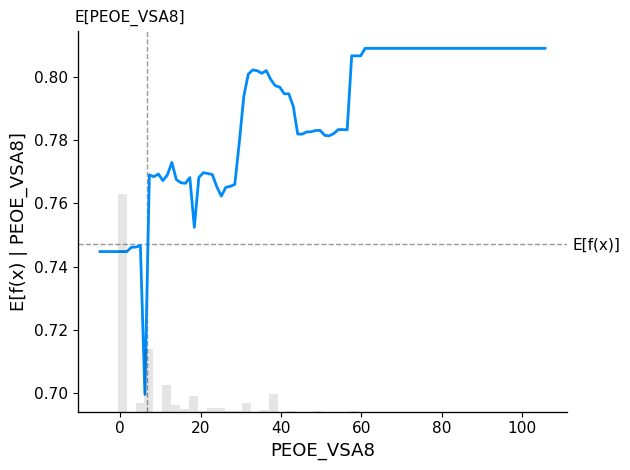

In [176]:
pdp_dict['PEOE_VSA8']

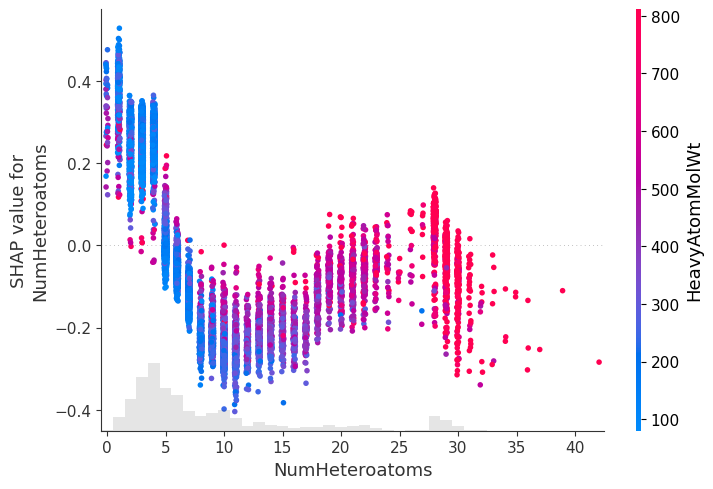

In [177]:
scatter_dict['NumHeteroatoms']

In [139]:
import shap
def shap_explainer(model, X):
    explainer = shap.Explainer(model, algorithm ='tree')
    shap_values = explainer(X)
    return shap_values, explainer



explainer = shap.Explainer(automl1.model.estimator, algorithm ='tree')
shap_values = explainer(X)

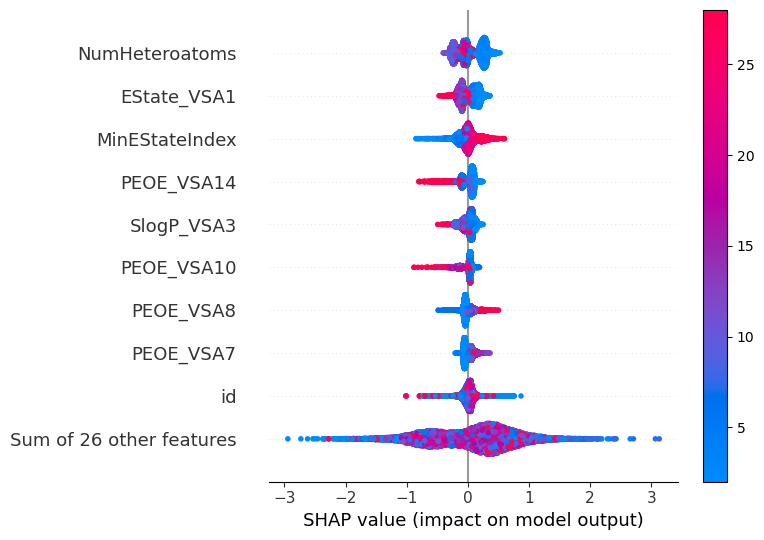

In [150]:
summary_dict['beeswarm']

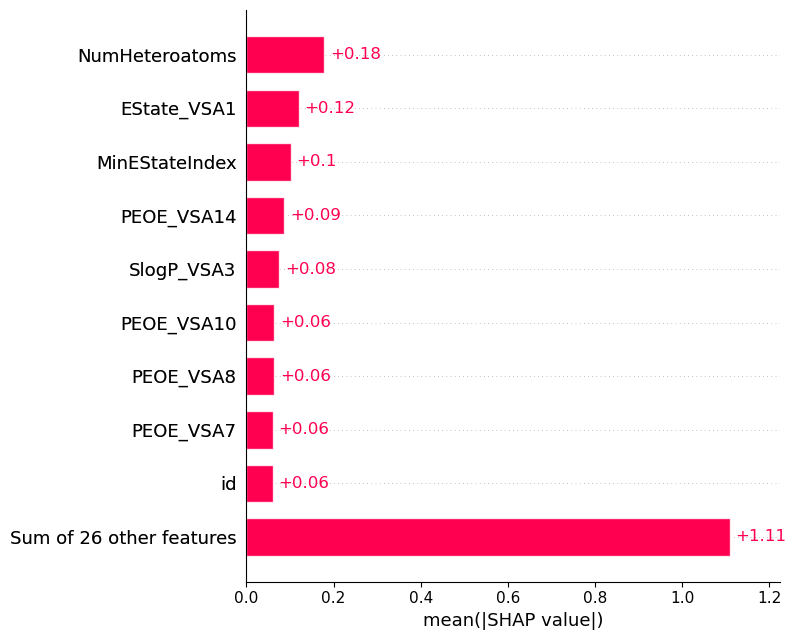

In [148]:
summary_dict['bar']

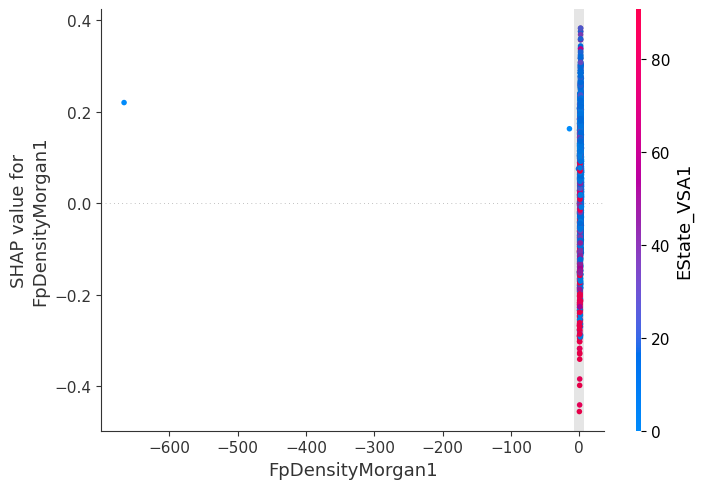

In [147]:
scatter_dict[feature]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [146]:
# shap.plots.beeswarm(shap_values, show=False, color_bar=False)
# plt.colorbar()
# plt.tight_layout()
# plt.show()

In [40]:
plt.colorbar()
plt.show()

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

<Figure size 640x480 with 0 Axes>

In [32]:
shap.__version__

'0.42.0'

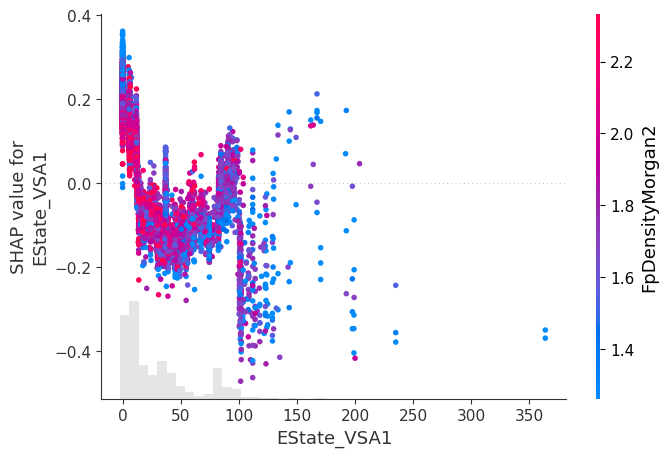

In [37]:
import matplotlib.pyplot as plt
shap.plots.scatter(shap_values[:,'EState_VSA1'], color=shap_values, show=False)

In [36]:
plt.show()

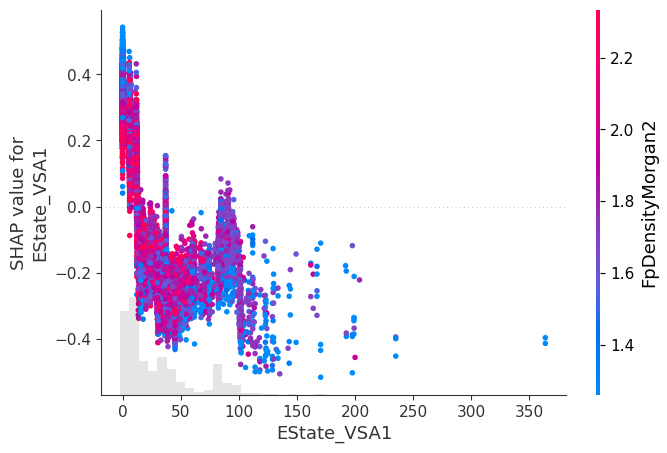

In [ ]:
shap.plots.scatter(shap_values[:,'EState_VSA1'][:,1], color=shap_values[:,:,1])

In [312]:
shap.plots.scatter(shap_values[:,21][:,1], color=shap_values[:,:,1])

IndexError: list index out of range

In [ ]:
# shap.plots.scatter(shap_values[:,21], color=shap_values, show=False)

In [309]:
idx

array([21,  9, 25, 17, 13,  1, 19, 15, 29, 32, 31,  7, 22,  5, 10, 28, 12,
       14, 23, 20, 27,  2, 30,  3, 16, 33, 34,  8, 24, 26, 18, 11,  4,  6,
        0])

In [311]:
shap_values[:,21]

IndexError: list index out of range

In [310]:
for i in idx[:10]:
    print(i)
    shap.plots.scatter(shap_values[:,i][:,1], color=shap_values[:,:,1], show=False)

21


IndexError: list index out of range

EState_VSA1


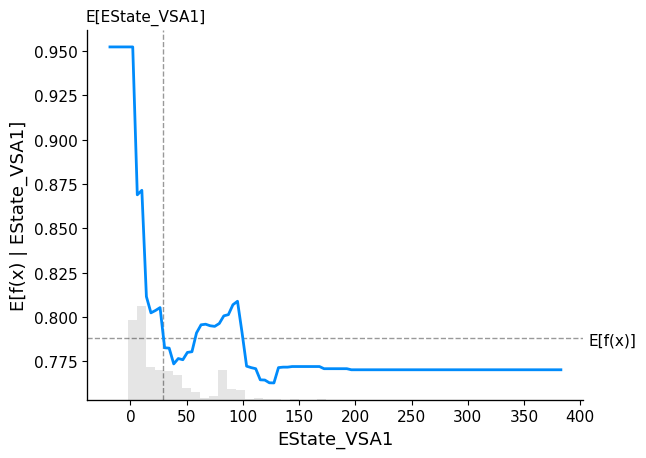

MinEStateIndex


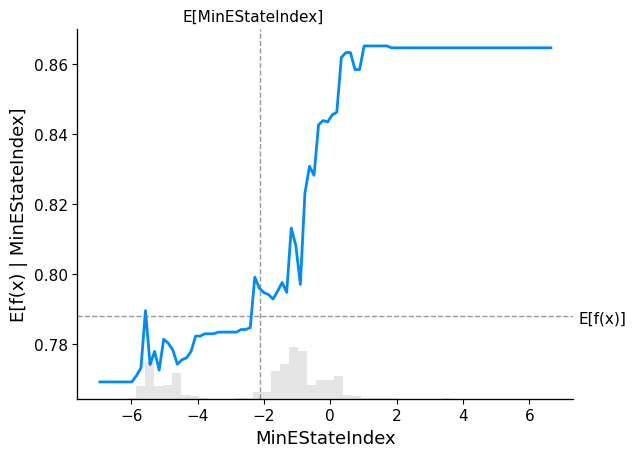

PEOE_VSA8


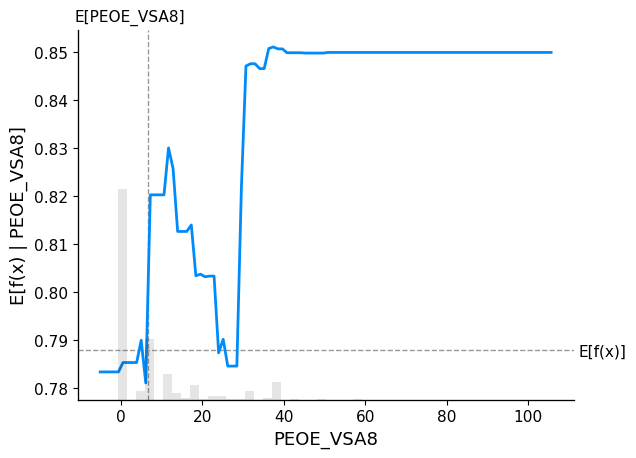

NumHeteroatoms


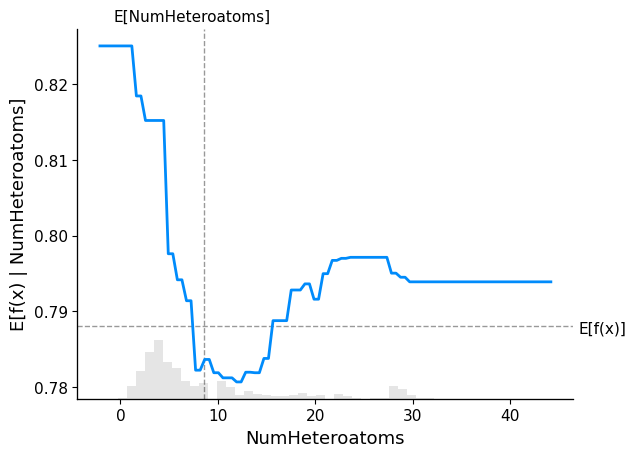

PEOE_VSA10


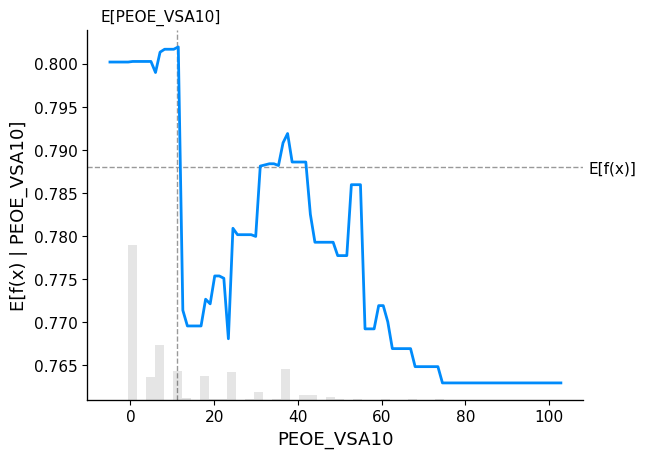

Kappa3


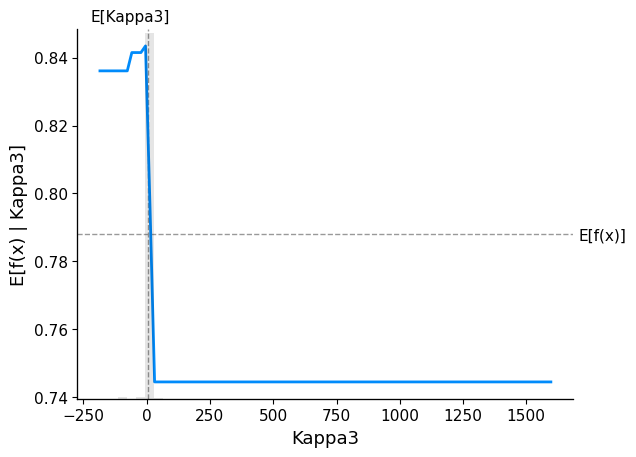

BertzCT


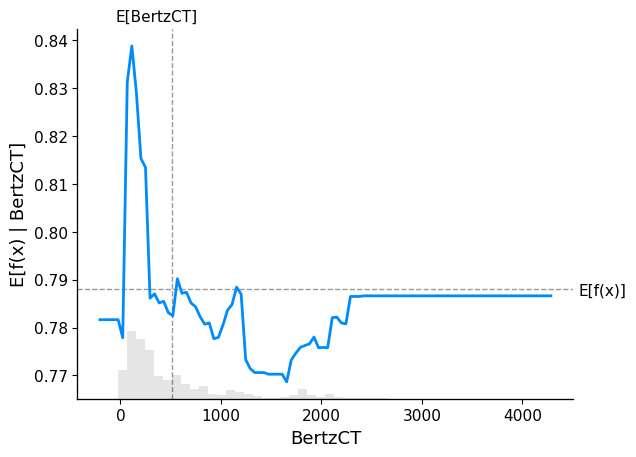

SlogP_VSA3


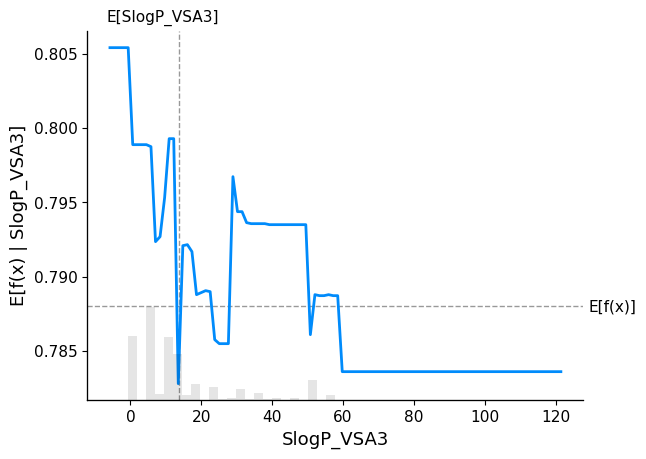

MolWt


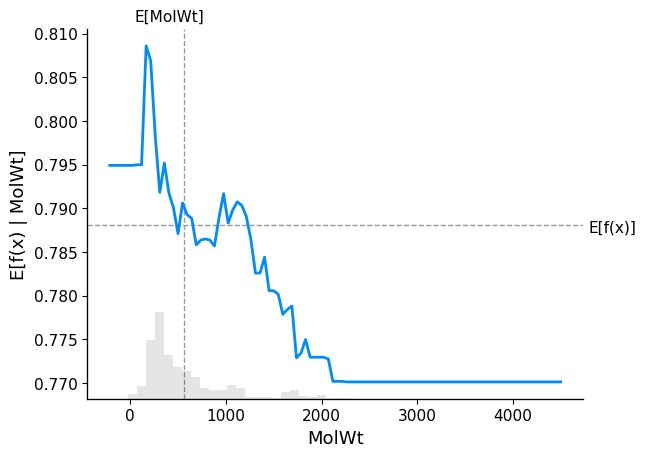

PEOE_VSA14


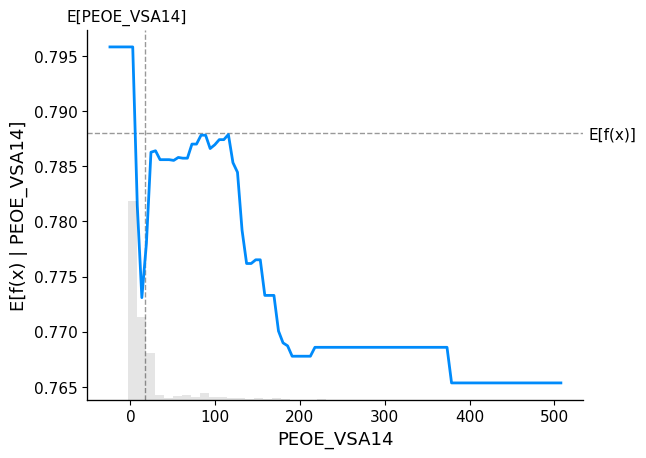

PEOE_VSA6


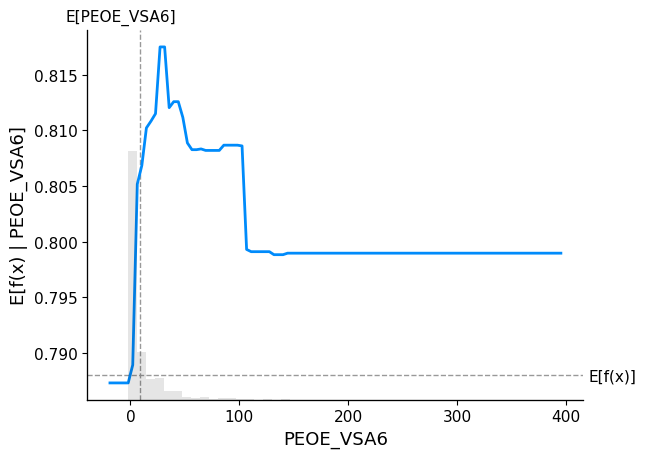

HeavyAtomMolWt


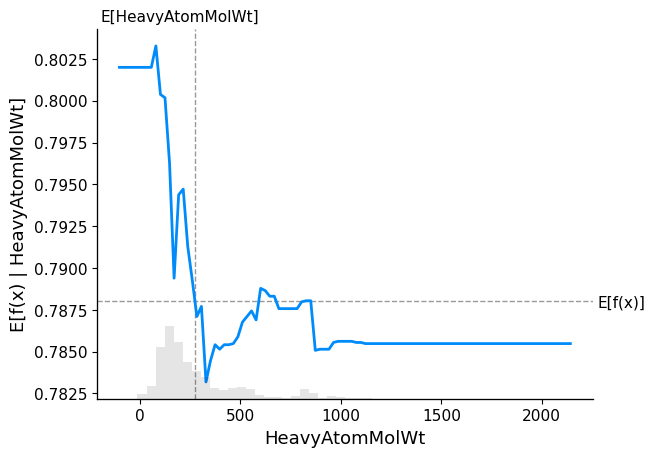

VSA_EState9


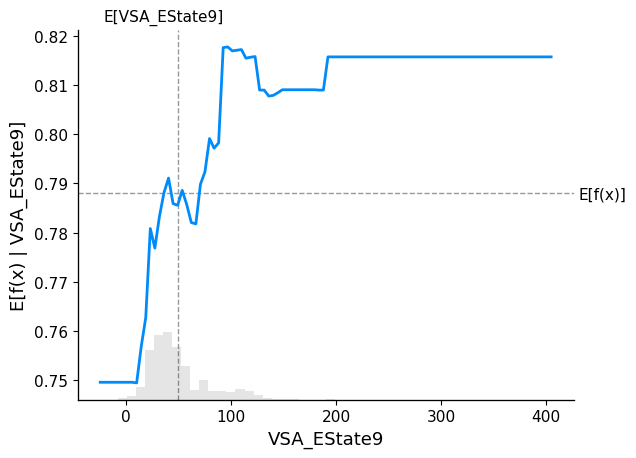

FpDensityMorgan2


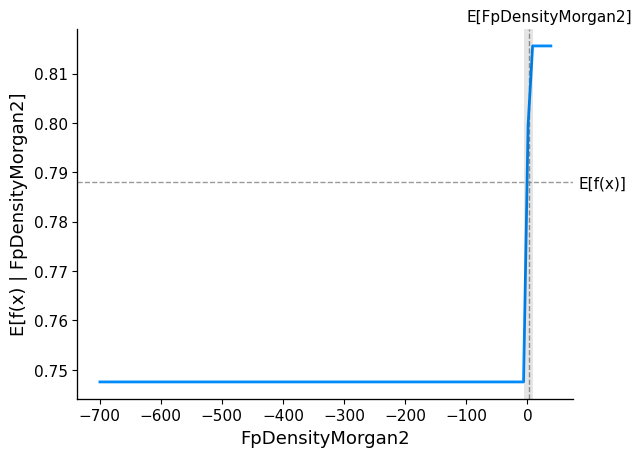

ExactMolWt


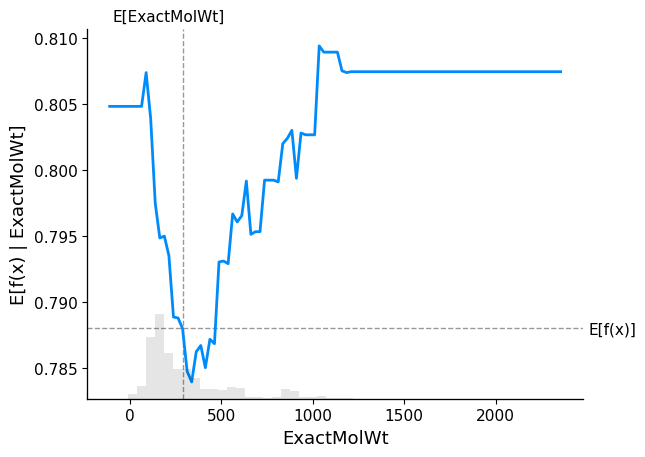

PEOE_VSA7


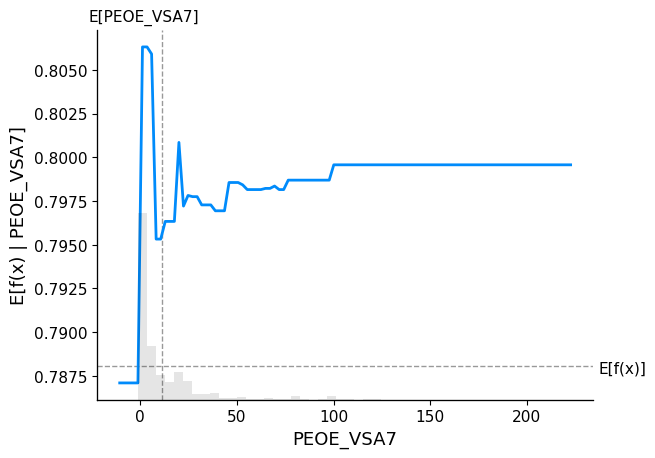

NumAromaticRings


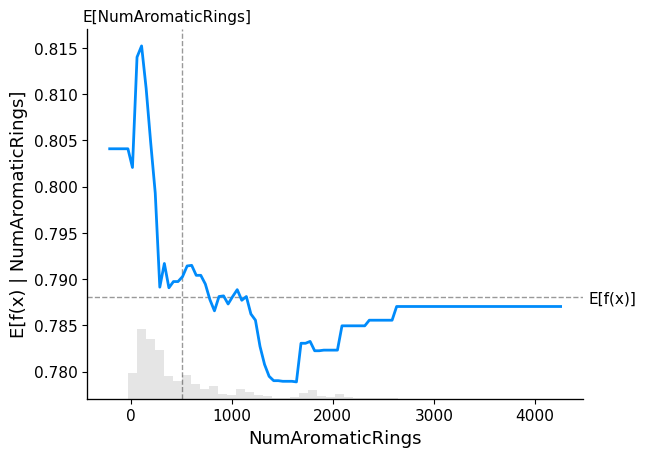

Chi2n


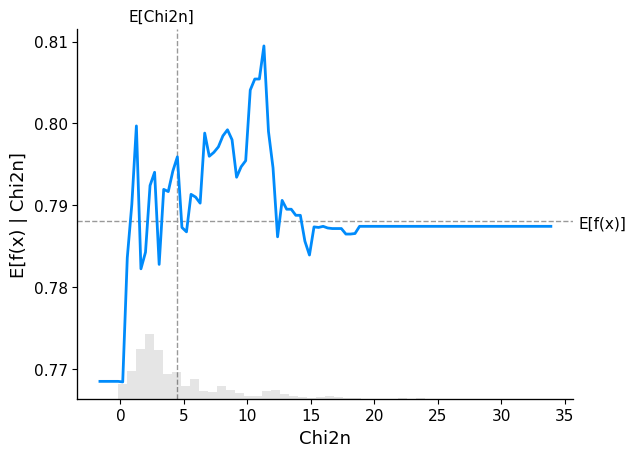

SMR_VSA5


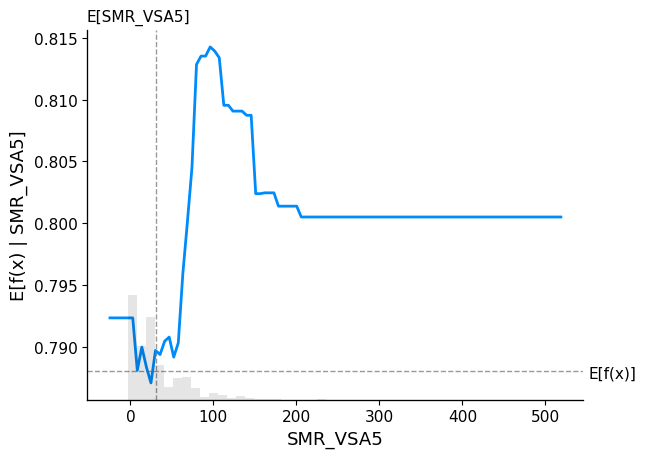

Chi3v


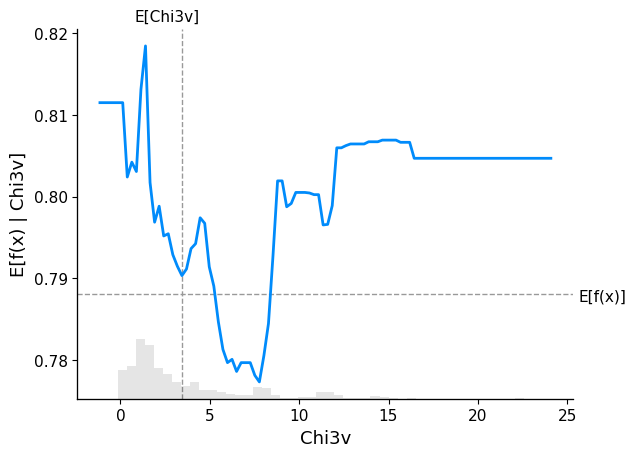

NumRotatableBonds


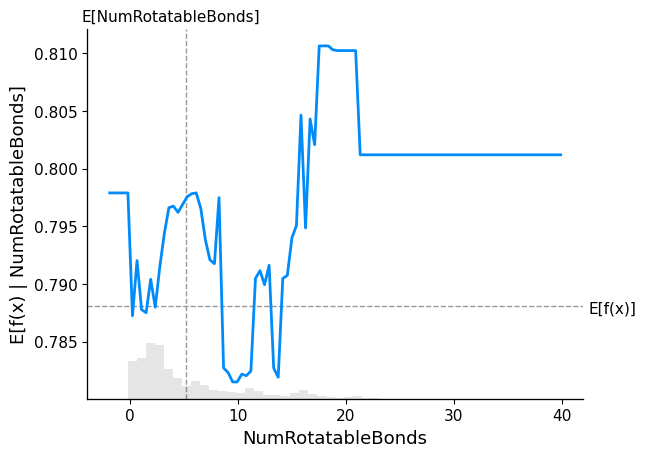

Chi1


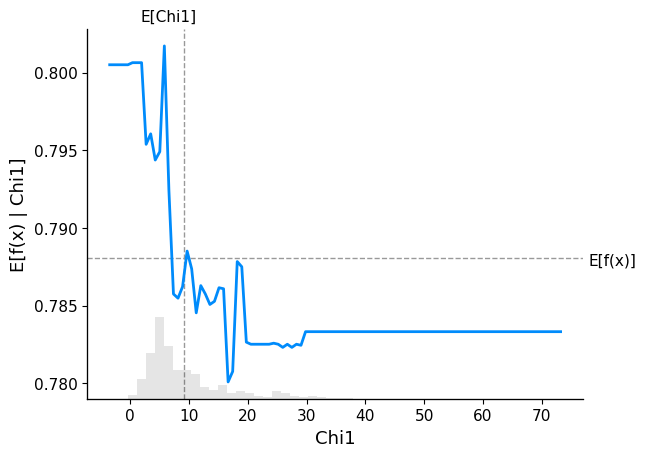

HallKierAlpha


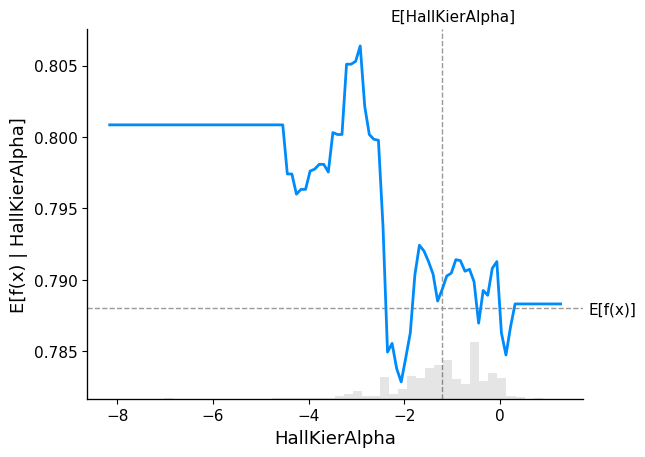

FpDensityMorgan1


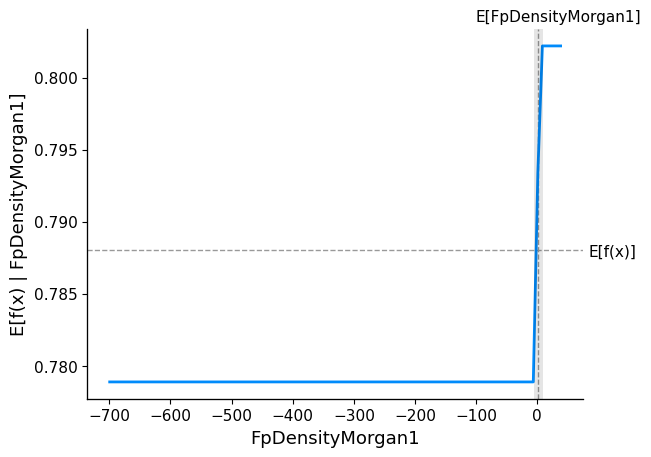

MaxAbsEStateIndex


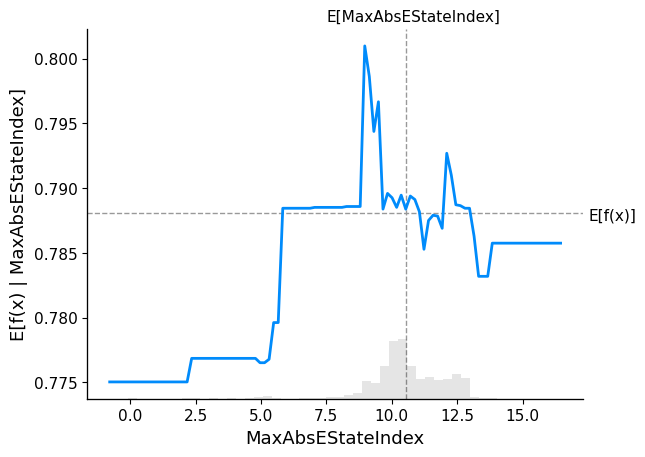

EState_VSA2


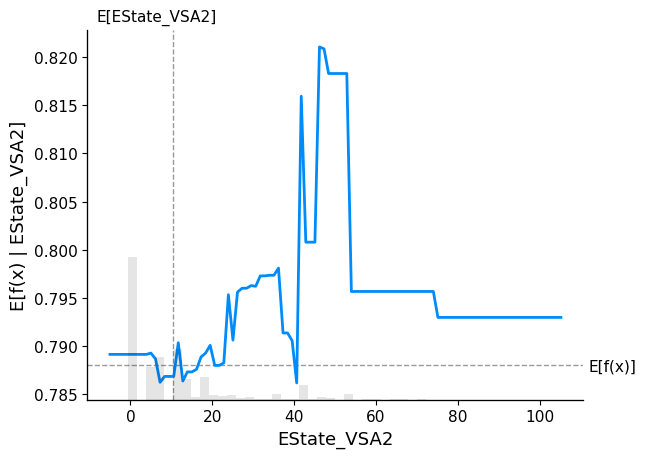

Chi1n


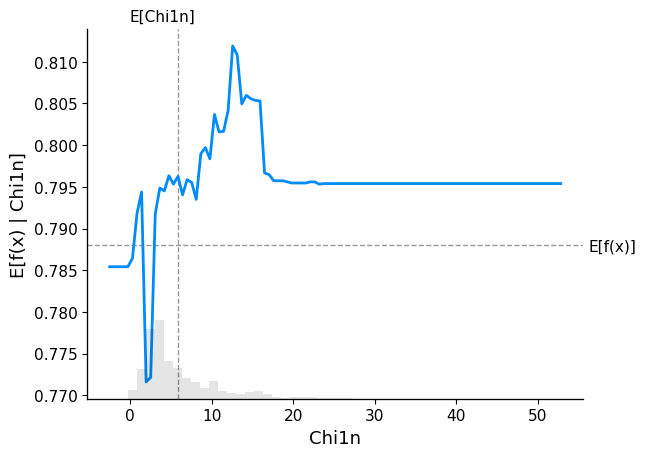

Chi1v


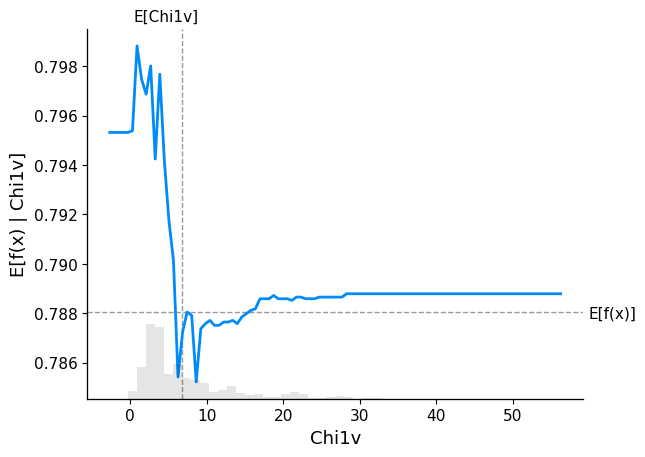

SMR_VSA10


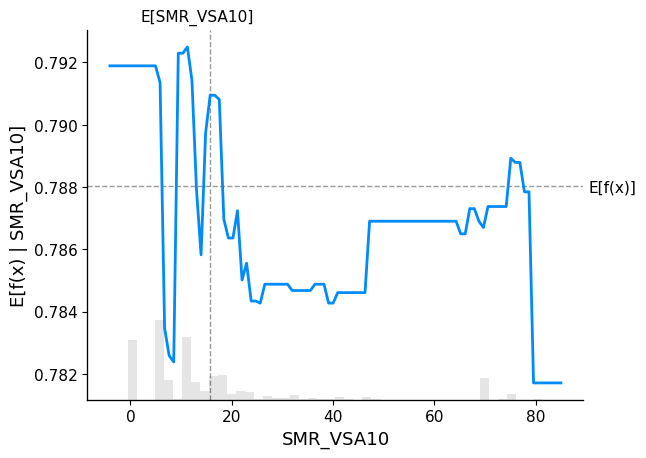

Chi2v


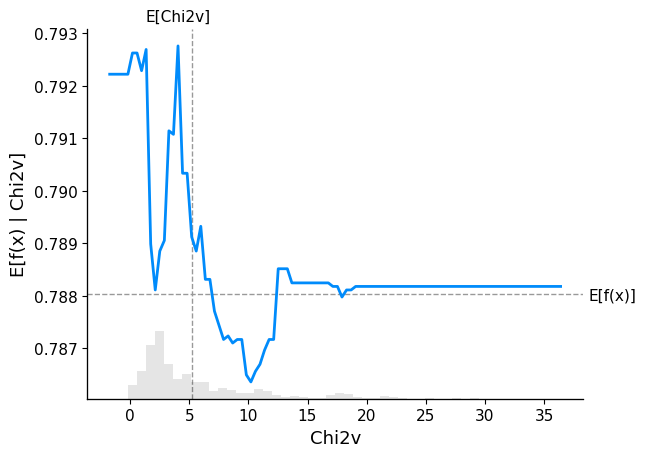

Chi4n


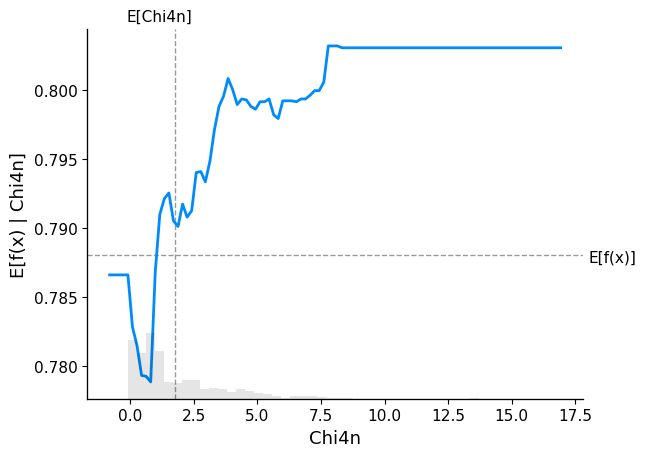

FpDensityMorgan3


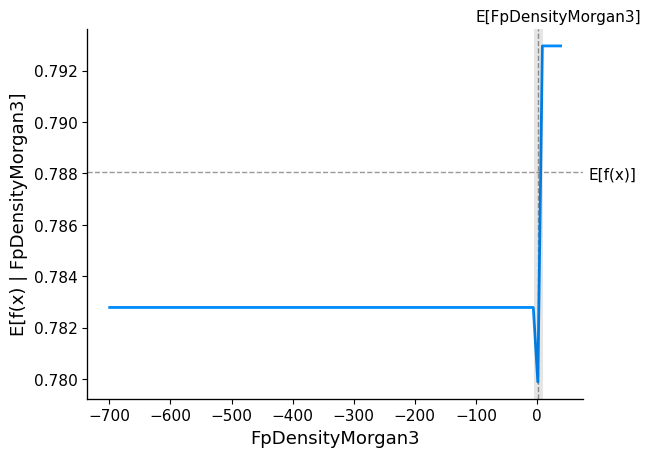

id


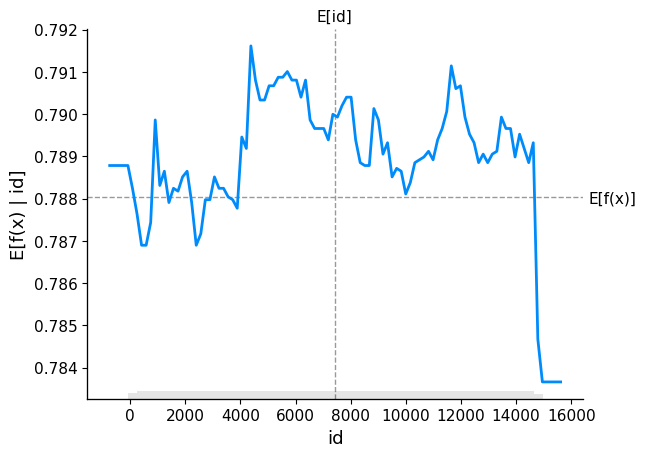

fr_COO2


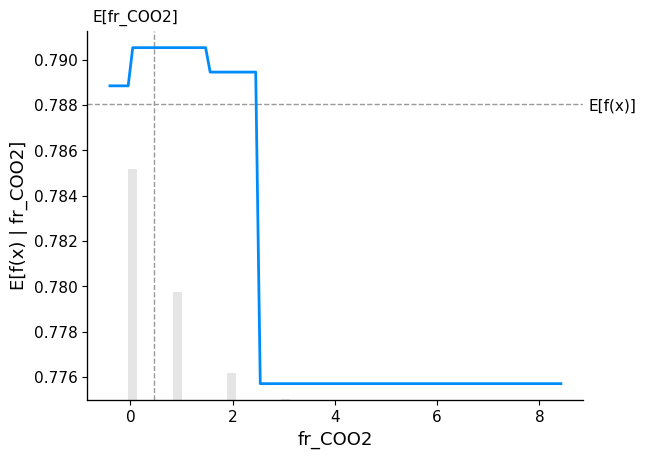

fr_COO


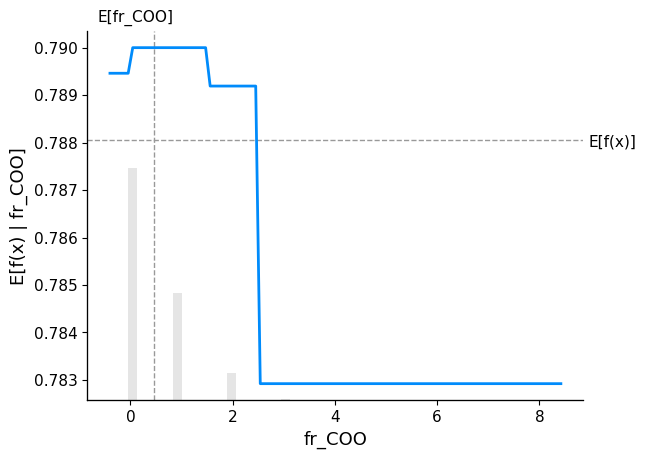

In [245]:
for i in list_[:10]:
    print(i)
    shap.partial_dependence_plot(
    i, automl1.predict, X, ice=False,
    model_expected_value=True, feature_expected_value=True
)

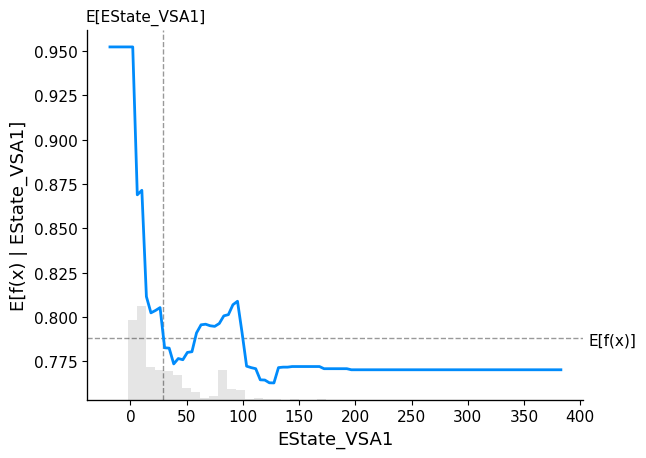

In [216]:
shap.partial_dependence_plot(
    'EState_VSA1', automl1.predict, X, ice=False,
    model_expected_value=True, feature_expected_value=True
)

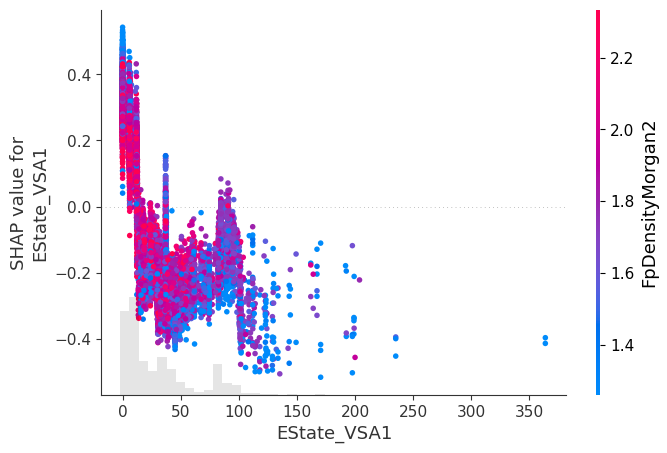

In [210]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(nrows=1, ncols=1)
figb = shap.plots.scatter(shap_values[:,"EState_VSA1"][:, 1], color=shap_values[:, :,1], show=False)

In [211]:
figb

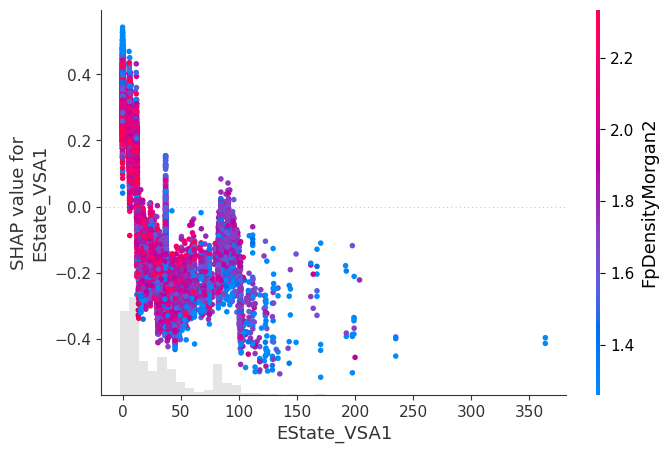

In [199]:
# import matplotlib.pyplot as plt
# ax, fig =  plt.subplots(figsize=(10, 10), nrows=1, ncols=1)
fig = shap.plots.scatter(shap_values[:,"EState_VSA1"][:, 1], color=shap_values[:, :,1], show=False,)

In [198]:
# fig = shap.plots.scatter(shap_values[:,"EState_VSA1"][:, 1], color=shap_values[:, :,1], show=False)

In [191]:
fig

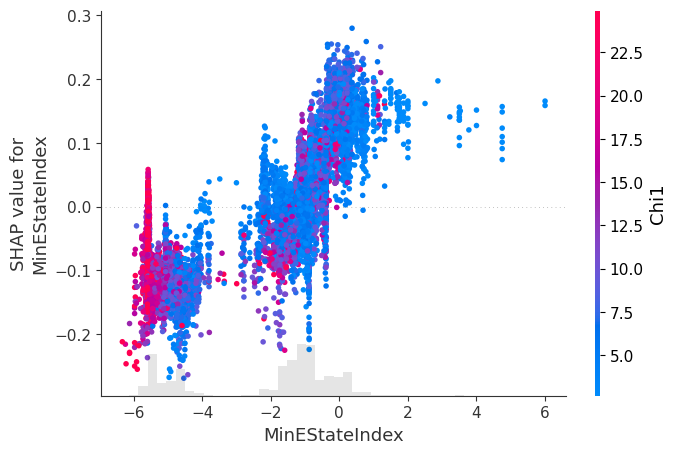

In [165]:
shap.plots.scatter(shap_values[:,"MinEStateIndex"][:, 1], color=shap_values[:, :,1])

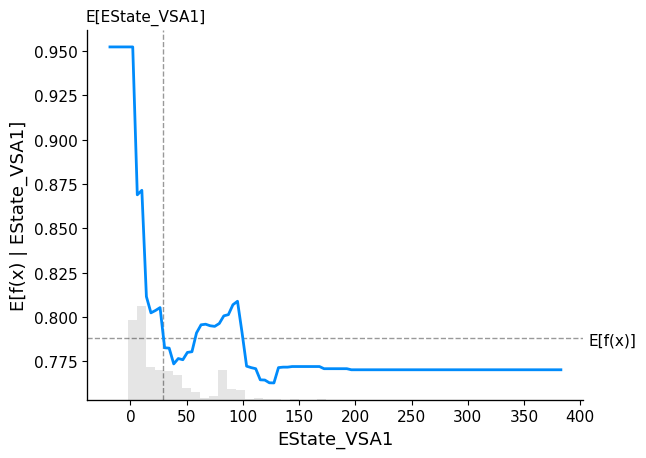

In [149]:
shap_values

.values =
array([[ 0.01297998,  0.01666345,  0.01657163, ...,  0.03223039,
        -0.00267369, -0.00482847],
       [-0.00827795, -0.02266484, -0.05102421, ..., -0.04299178,
        -0.02249051, -0.01842182],
       [ 0.00292529, -0.01878453, -0.03233372, ..., -0.04841201,
         0.00093588, -0.00707221],
       ...,
       [-0.02438564, -0.08685643,  0.01810261, ...,  0.02237769,
         0.00900402, -0.02293965],
       [-0.05095842, -0.0294929 , -0.00053716, ..., -0.06783337,
        -0.02614768, -0.01760147],
       [-0.02899467, -0.07323265, -0.02104253, ..., -0.04145866,
        -0.04248224, -0.04212125]])

.base_values =
array([0.79138071, 0.79138071, 0.79138071, ..., 0.79138071, 0.79138071,
       0.79138071])

.data =
array([[0.00000000e+00, 3.23390782e+02, 9.87991785e+00, ...,
        4.34231080e+02, 4.50371624e+00, 3.13510864e+02],
       [1.00000000e+00, 2.73723798e+02, 7.25903748e+00, ...,
        5.07060719e+02, 3.49114941e+00, 2.66464760e+02],
       [2.00000000e+00, 

In [148]:
shap.plots.scatter(shap_values[:, 'EState_VSA1'])

IndexError: list index out of range